# P2 Feature Detection, Feature Matching and Image Warping

## P2.1 Harris Corners

Now that you've learned about Harris Corners, you're going to implement this procedure.

1. Compute the gradient at each point in the image
2. Compute the H matrix (or at least the elements of it) from the elements of the gradient
3. Compute the scoring function (perhaps by computing the eigenvalues)
4. Find points with a large response (threshold f)
5. Find local maxima of f after thresholding (you will need to pick what you think is a "reasonable" threshold)

Where the Harris matrix $H$ is defined by
$$ H = \sum_{(x, y) \in W} w_{x, y} \begin{bmatrix}
I_x^2 & I_x I_y \\ I_x I_y & I_y^2
\end{bmatrix} $$
and $I_x$ is the $x$-derivative of the image $I$, $I_y$ is the $y$-derivative of the image $I$ and $w$ is a weight matrix. Use the Sobel filter to compute the image derivatives. You can use either definition of $f$ we introduced in class:

$$ f = min(\lambda_1, \lambda_2) $$
$$ f = \frac{\text{det}(H)}{\text{tr}(H)} $$

I have provided you with a local-maxima-finding function for you to use.

**Note that you should be completing this solution without any external packages: you should be computing the image derivatives and the Harris corners themselves yourself.** Using external packages to check your solutions is acceptable, but your answer will no doubt be slightly different than those packages.

### P2.1.1 Computing Harris Corners

Generate a figure that shows the following intermediate steps during the computation of Harris Corners on the provided:
1. The original image
2. The $x$ and $y$ derivatives of the image, as computed via the Sobel filters.
3. The scoring function $f$
4. The original image with dots showing the location of the detected corners. (Be sure to choose a *reasonable* threshold; you should expect to end up with on the order of a few dozen features. If you have thousands of features, your threshold is too low. If you have only one or two features, your threshold is too high.

For this first part, you should use a *uniform weight matrix of size 5x5* (`weights = np.ones((5, 5))/25`) when computing the scoring function. We will change this in the next part of the question. 

Are the features where you expected? Are there any features in the image that you are surprised are not present? Highlight one or two regions of the image where features were detected that you did not expect (or one or two regions you thought features might exist).

In class, we derived the Harris matrix and a special scoring function related to the eigenvalues of that matrix so that we could measure the *cornerness* of the image. What would happen if you used a scoring function $f = \text{tr}(H) = A + C$? Plot this alternative scoring function for the `light_cubes_base` image and plot the detected features computed using it. What does this scoring function detect? If we want to detect corners, why might we not want to use this scoring function?

### P2.1.2 Varying the Weight Matrix

In this part, we will see what happens when we use different weight matrices. Plot the score function $f$ (one of the ones we discussed in class) and the detected corners for each of the following weight functions:

1. A uniform weight matrix of size 5x5 `weights = np.ones((5, 5))/25` (same as in the previous question).
2. A uniform weight matrix of size 25x25 `weights = np.ones((25, 25))/25/25`
3. A Gaussian weight matrix with $\sigma = 5$
4. A Gaussian weight matrix with $\sigma = 50$

Discuss the differences between these functions. In particular, what happens when the filter width (or $\sigma$) is very large?

What happens if we were to use a 1x1 weight matrix $w = 1$? Why does this occur?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal
import scipy.ndimage.filters as filters

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

def get_local_maxima(data, threshold):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 3

    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    for dy, dx in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        
    return np.array(list(zip(x, y)))

# Some example code showing that it works
signal = np.random.rand(50, 50)
fig = plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(signal, cmap='gray')
points = get_local_maxima(signal, threshold=0.95)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

image = load_image("light_cubes_base.png")[:, :, 0]
plt.figure(dpi=300)
plt.imshow(image)
plt.show()
None

<Figure size 1200x1200 with 1 Axes>

<Figure size 1920x1440 with 1 Axes>

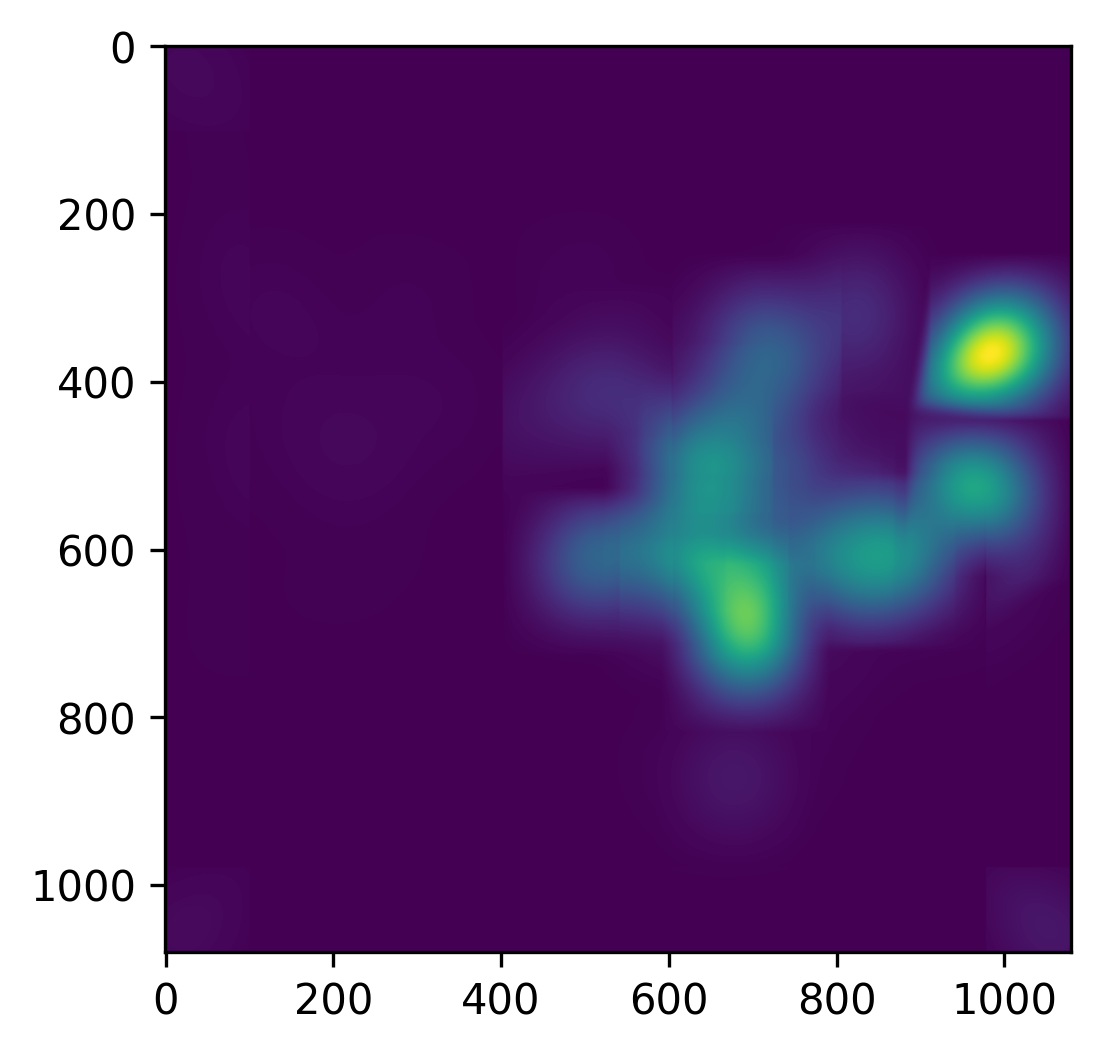

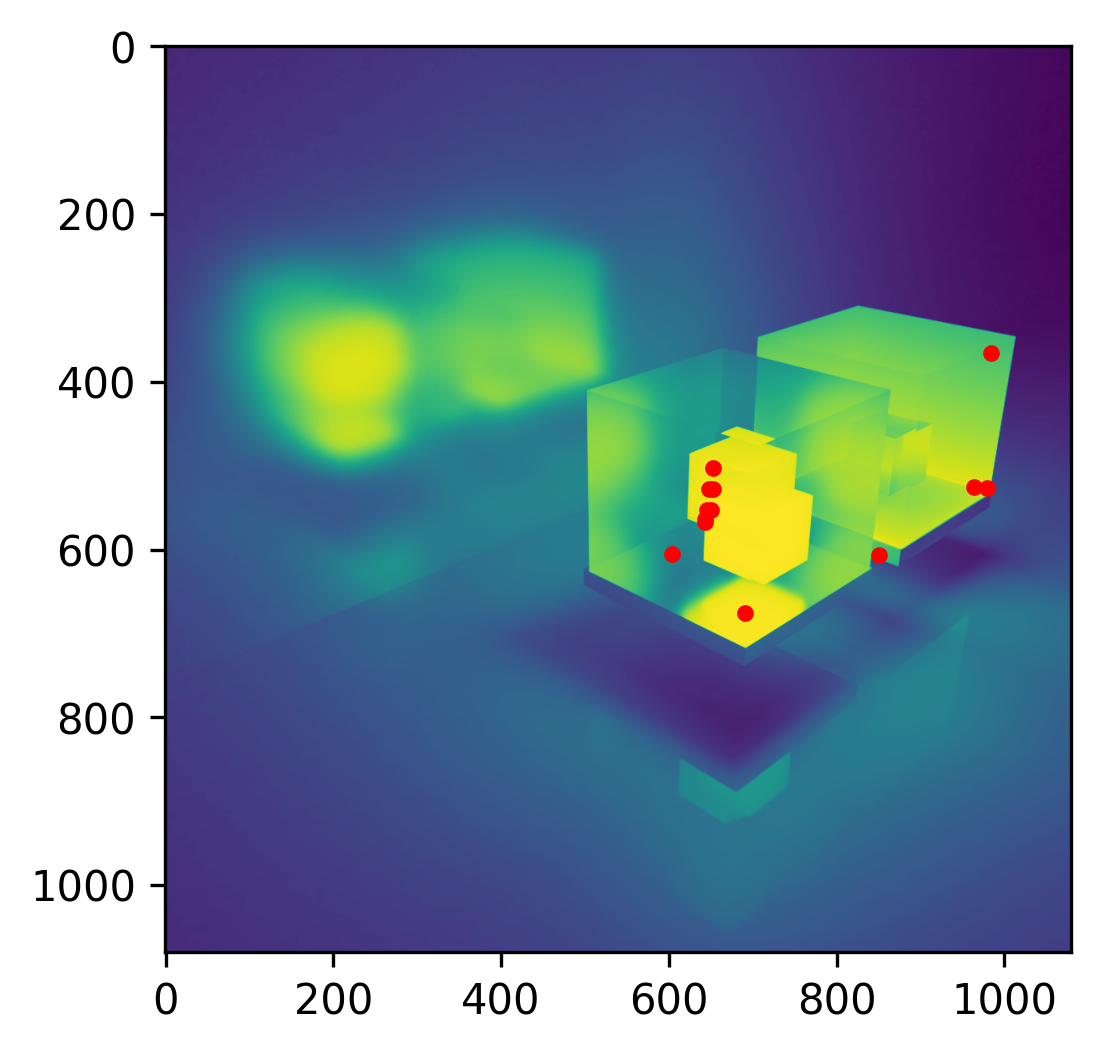

In [2]:
# Solution

def get_gaussian_filter(n, sigma=1):
    assert(n % 2 == 1)
    h = (n + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Take the gaussian
    g = np.exp(-d_sq/2/(sigma**2))
    # Normalize
    g = g/g.sum().sum()
    return g

def get_harris_components(image, weights):
    sobel_x = np.array([
      [1, 0, -1],
      [2, 0, -2],
      [1, 0, -1]
    ])

    sobel_y = np.array([
      [1, 2, 1],
      [0, 0, 0],
      [-1, -2, -1]
    ])

    Ix = scipy.signal.convolve(
        image, sobel_x, mode='same')
    Iy = scipy.signal.convolve(
        image, sobel_y, mode='same')

    # Compute the Harris operator matrix
    w = weights
    A = scipy.signal.convolve(
        Ix * Ix, w, mode='same')
    B = scipy.signal.convolve(
        Ix * Iy, w, mode='same')
    C = scipy.signal.convolve(
        Iy * Iy, w, mode='same')
    return (A, B, C)

def get_harris_score(image, weights):
    A, B, C = get_harris_components(image, weights)
    det = A*C - B*B
    tr = A + C
    f = det/tr
    return f
    # return get_local_maxima(f, threshold=0.01)


image = load_image("light_cubes_base.png")[:, :, 0]
sigma = 50
weights = get_gaussian_filter(201, sigma=50)
# weights = np.ones((25, 25))/25/25
# weights = np.ones((5, 5))/25
# weights = [[1]]

f = get_harris_score(image, weights)
corners = get_local_maxima(f, threshold=0.01)


plt.figure(dpi=300)
plt.imshow(f)

plt.figure(dpi=300)
plt.imshow(image)
plt.plot(corners[:, 0], corners[:, 1], 'r.')

## P2.2 Multi-scale Blob Detection

Here, we will be building on the in-class breakout session to experiment with using the (normalized) Laplacian of Gaussian (LoG) filter to detect "blobs" in an image and their scale.

### P2.2.1 Scale-Normalized Filter Response

In this question, I have provided you with a simple "circle image", in which a filled circle is placed at the center of a square image. Here, you know that the circle is the feature you are trying to detect and that its location is at the center, so the feature does not need to be *located*. Instead, you are asked to find the radius of the circle (the "blob feature" of interest).

First, you will need to define the LoG filter function `get_LoG_filter(kernel_size, sigma)` using either the in-class notes or [this resource](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm). Once you have computed the normalized LoG filter, apply it at multiple scales to the sample circle image I have provided you with. Plot "filter response" (the value of the image after the filter is applied) at the center of the circle versus $\sigma$. Confirm that the peak of the filter response at the center of the circle occurs at the $\sigma$ we expect. (Recall that the peak $\sigma$ value does not correspond to the radius of the circle. What is the relationship between the peak $\sigma$ and the circle's radius?)

**Note:** If you use the *unnormalized Laplace of Gaussian Filter*, the maximal feature response will not occur where you expect. Be sure to use the correct filter function.

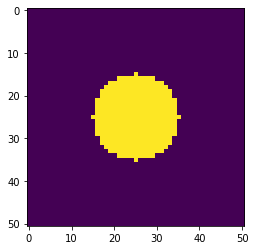

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def get_circ_image(image_size, radius):
    """Create an image of width `image_size` with a circle 
    of radius `radius` in its center."""
    assert(image_size % 2 == 1)
    h = (image_size + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Threshold by squared radius
    d_sq = (d_sq <= radius**2).astype(np.float)
    return d_sq

def get_LoG_filter(kernel_size, sigma):
    raise NotImplementedError("Your task is to implement the LoG filter.")

def apply_filter(signal, filt):
    """Apply a filter to an image; wrapper around scipy."""
    return scipy.signal.convolve2d(signal, filt, mode='same')

im_half_size = 25
fig = plt.figure()
circ_img = get_circ_image(2 * im_half_size + 1, radius=10)
plt.imshow(circ_img)

None

###  P2.2.2 Annotating an Image with Multi-Scale Detections

Now, let's assume that we have an image with multiple features and we don't know either where they are or what their "radius" or "scale" is. Your goal here is to simultaneously detect features and estimate their characteristic scale.

For testing purposes, I have provided you with a simple image with two circles in it. Your task is to automatically identify where these "blobs" are and what their radius is. By the time you're done, you should be able to automatically detect the feature locations *and* their scale, producing images like the following: 

<img src="auto_feature_detection_result.png" width="400">

Similar to the Harris Features from the last exercise, the features occur at extrema (both maxima and minima) in image-space. Before we compute multi-scale features, pick 3 or 4 values of $\sigma$ and for each, plot the following:
1. The filter response (applying the scaled LoG filter for a particular $\sigma$ to the image function) and;
2. The location of the extrema plotted on top of the original image (just like the Harris Corner exercise from the previous programming assignment). To compute the corners, you may use the `get_local_maxima` function I have provided (the same as from the last assignment).

Now, we can put everything together. The multi-scale features we care about exist at extrema in both image space *and* in scale space. This will require computing the "blob" feature response in both image-space and in scale space (by iterating through different sigma values). Features will exist at extrema of $f$ in both image space and scale space. Your code for multi-scale blob detection will look something like the following:

```python
response = np.zeros(
    [image.shape[0], image.shape[1], sigmas.size]
)
for ii, sigma in enumerate(sigmas):
   filter = get_LoG_filter(kernel_size, sigma)
   filtered_image = apply_filter_to_image(image, filter)
   # Store the absolute value
   response[:, :, ii] = np.abs(feature_response)
   
features = get_local_maxima_3D(response)
```

Where you should implement the functions `get_LoG_filter`, `apply_filter_to_image` and `get_local_maxima_3D` (which you can write by extending the 2D version I have provided; the `maximum_filter` function works for 3D data).

Once you have computed the features, plot them as circles of the appropriate radius on top of three images: (1) the two-circle "test" image I have provided, (2) the "sunflower_field.jpg" image I have provided in this folder, and (3) a third image of your choosing.

[This resource](https://www.delftstack.com/howto/matplotlib/how-to-plot-a-circle-in-matplotlib/#matplotlib-patches-circle-method-to-plot-a-circle-in-matplotlib) will help you in drawing circles in matplotlib.

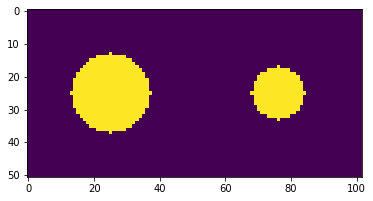

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.ndimage.filters as filters

def get_local_maxima(data, threshold):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 3

    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        
    return np.array(list(zip(x, y)))

fig = plt.figure()
sigmas = np.arange(2, 20, 0.1)
circ_img_a = get_circ_image(2 * im_half_size + 1, radius=12)
circ_img_b = get_circ_image(2 * im_half_size + 1, radius=8)
circ_img = np.concatenate([circ_img_a, circ_img_b], axis=1)
plt.imshow(circ_img)

None

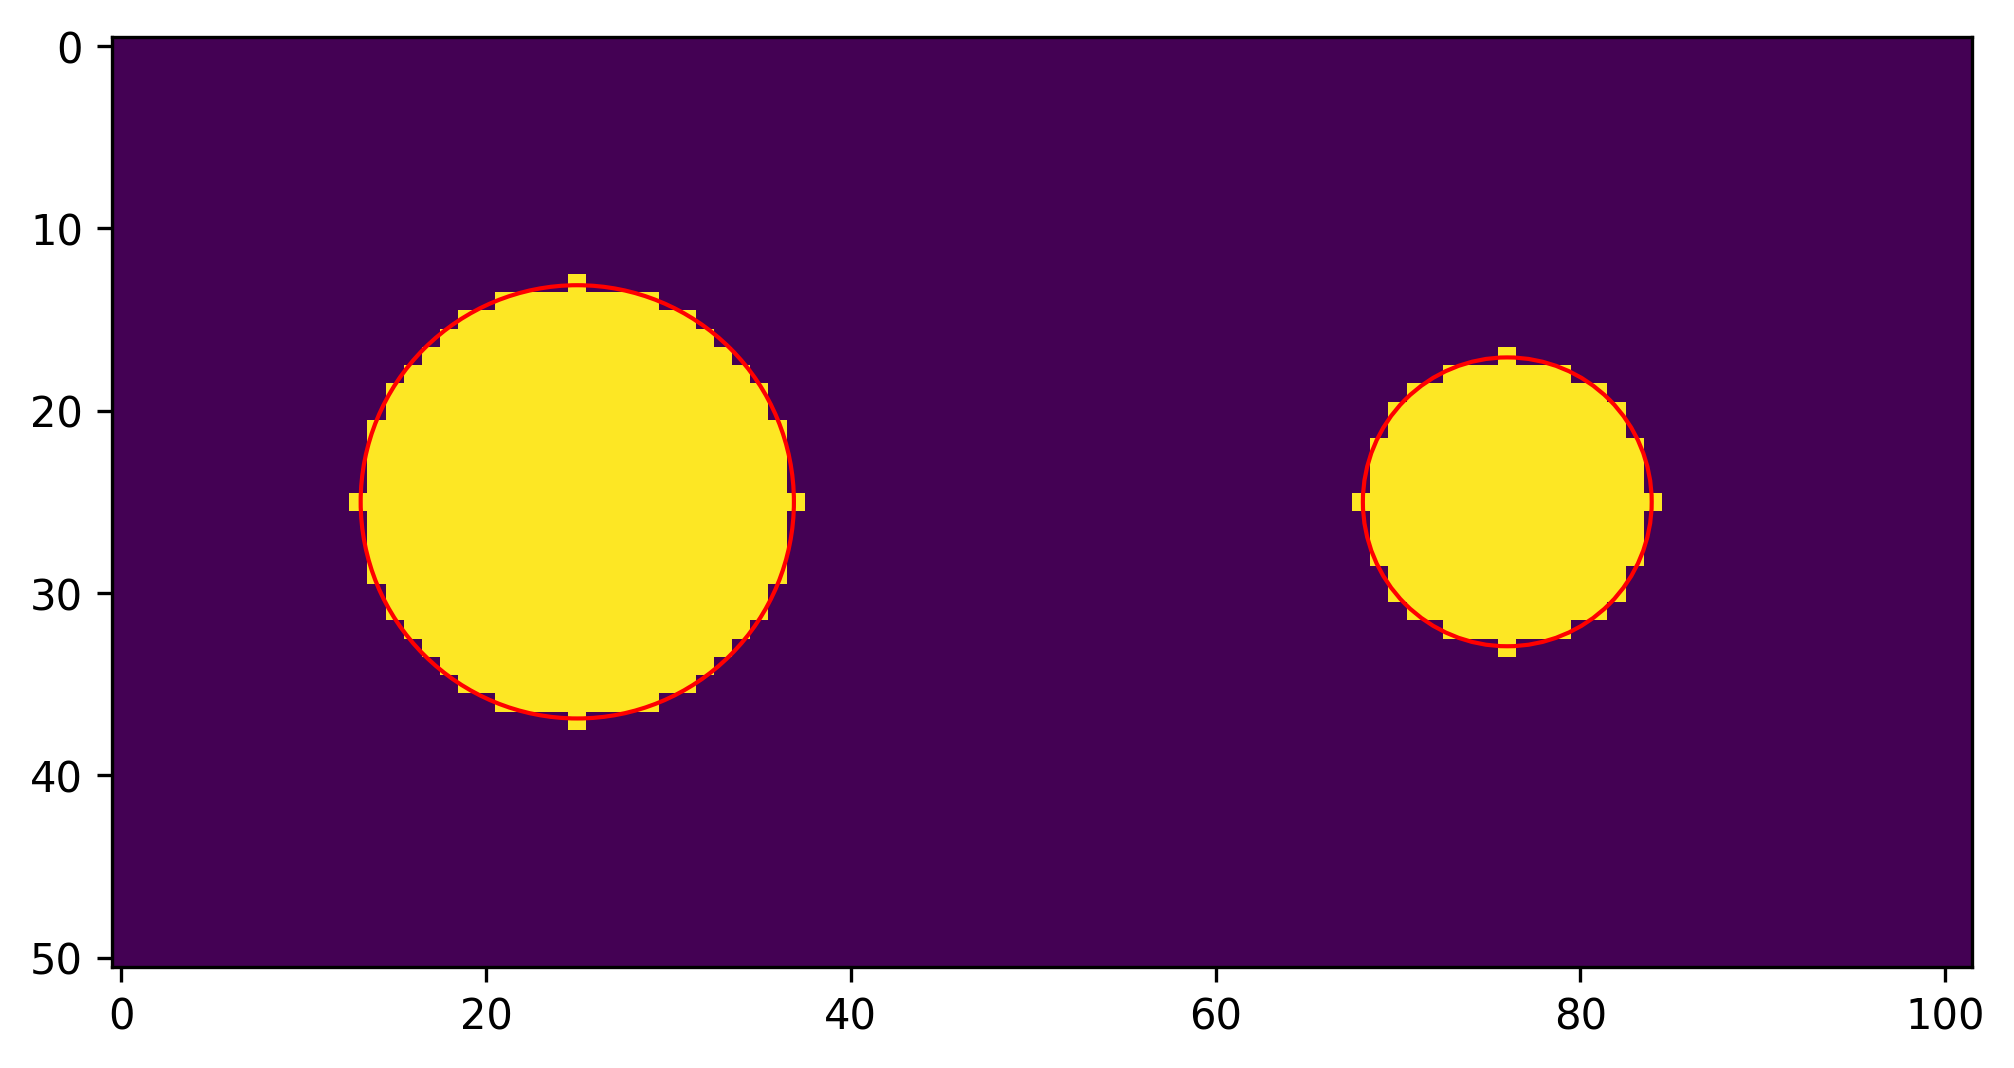

In [44]:
# Solution
import matplotlib.pyplot as plt

def get_LoG_filter(kernel_size, sigma):
    assert(kernel_size % 2 == 1)
    h = (kernel_size + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Implement the filter
    log = (1 - d_sq/2/(sigma**2)) * np.exp(-d_sq/2/(sigma**2)) / (sigma**2)
    return log

def get_local_maxima_3(data, threshold, sigmas, neighborhood_size=11):
    # See: https://stackoverflow.com/a/9113227/3672986
    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)

    features = []
    x, y = [], []
    for dy, dx, dz in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        y_center = int(round((dy.start + dy.stop - 1)/2))
        z_center = int(round((dz.start + dz.stop - 1)/2))
        features.append((x_center, y_center, sigmas[z_center]))
        
    return features

def compute_multi_scale_features(image, sigmas, threshold, window_size=11):
    response = np.zeros(
        [image.shape[0], image.shape[1], sigmas.size]
    )
    for ii, sigma in enumerate(sigmas):
        w = get_LoG_filter(101, sigma=sigma)
        feature_response = scipy.signal.convolve(
            image, w, mode='same')
        response[:, :, ii] = np.abs(feature_response)
    
    return get_local_maxima_3(response, threshold, sigmas=sigmas,
                             neighborhood_size=window_size)

def plot_circ_features(image, features, ax):
    ax.imshow(image)
    for m in features:
        #if m[2] == sigmas.max():
        #    continue
        cir = plt.Circle((m[0], m[1]), np.sqrt(2)*m[2], color='r', fill=False)
        ax.add_artist(cir)

# Show for the circle image
image_base = circ_img
sigmas = np.arange(1.0, 10.0, 0.2)
features = compute_multi_scale_features(image_base, sigmas, 1.2)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

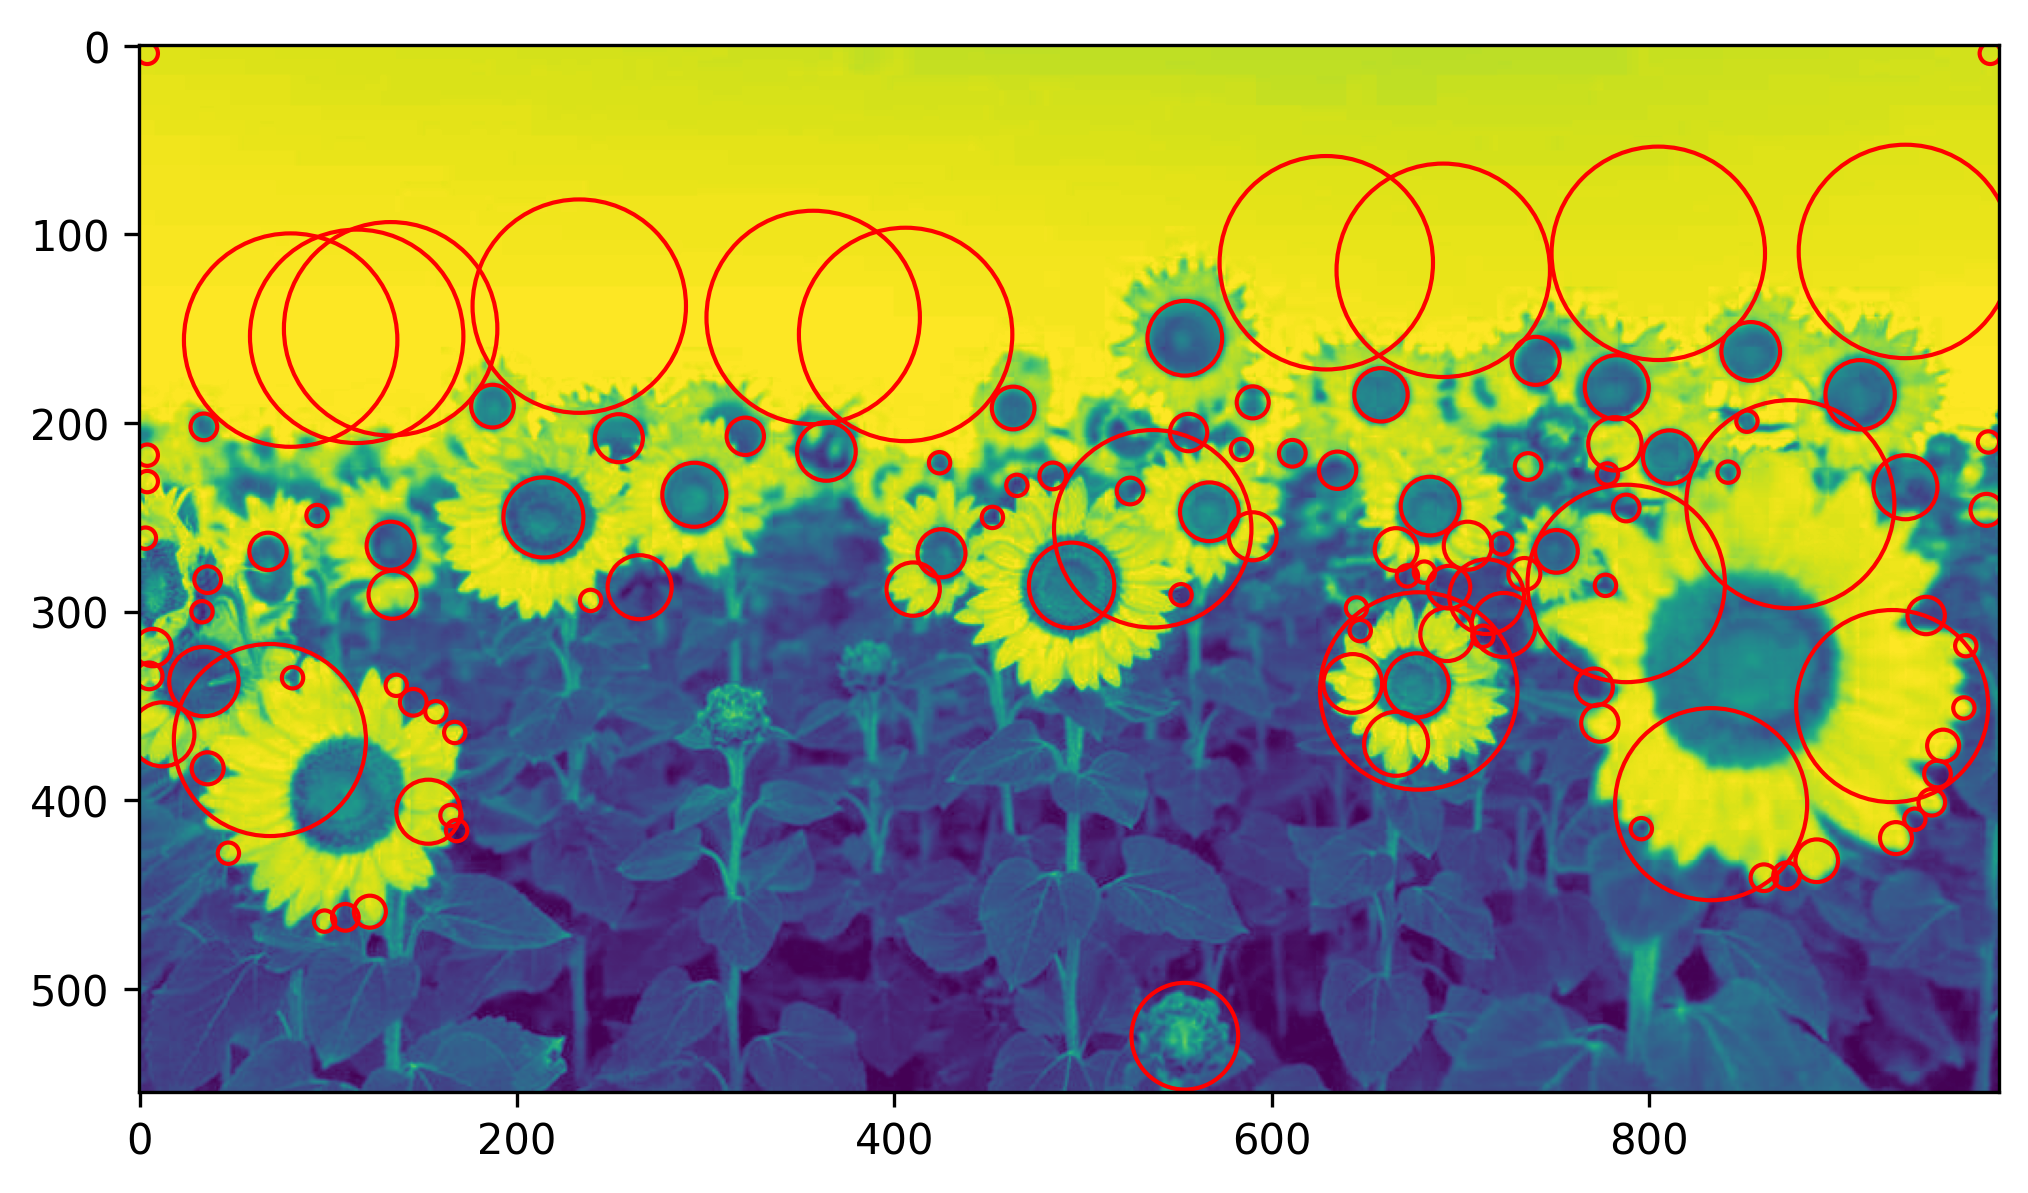

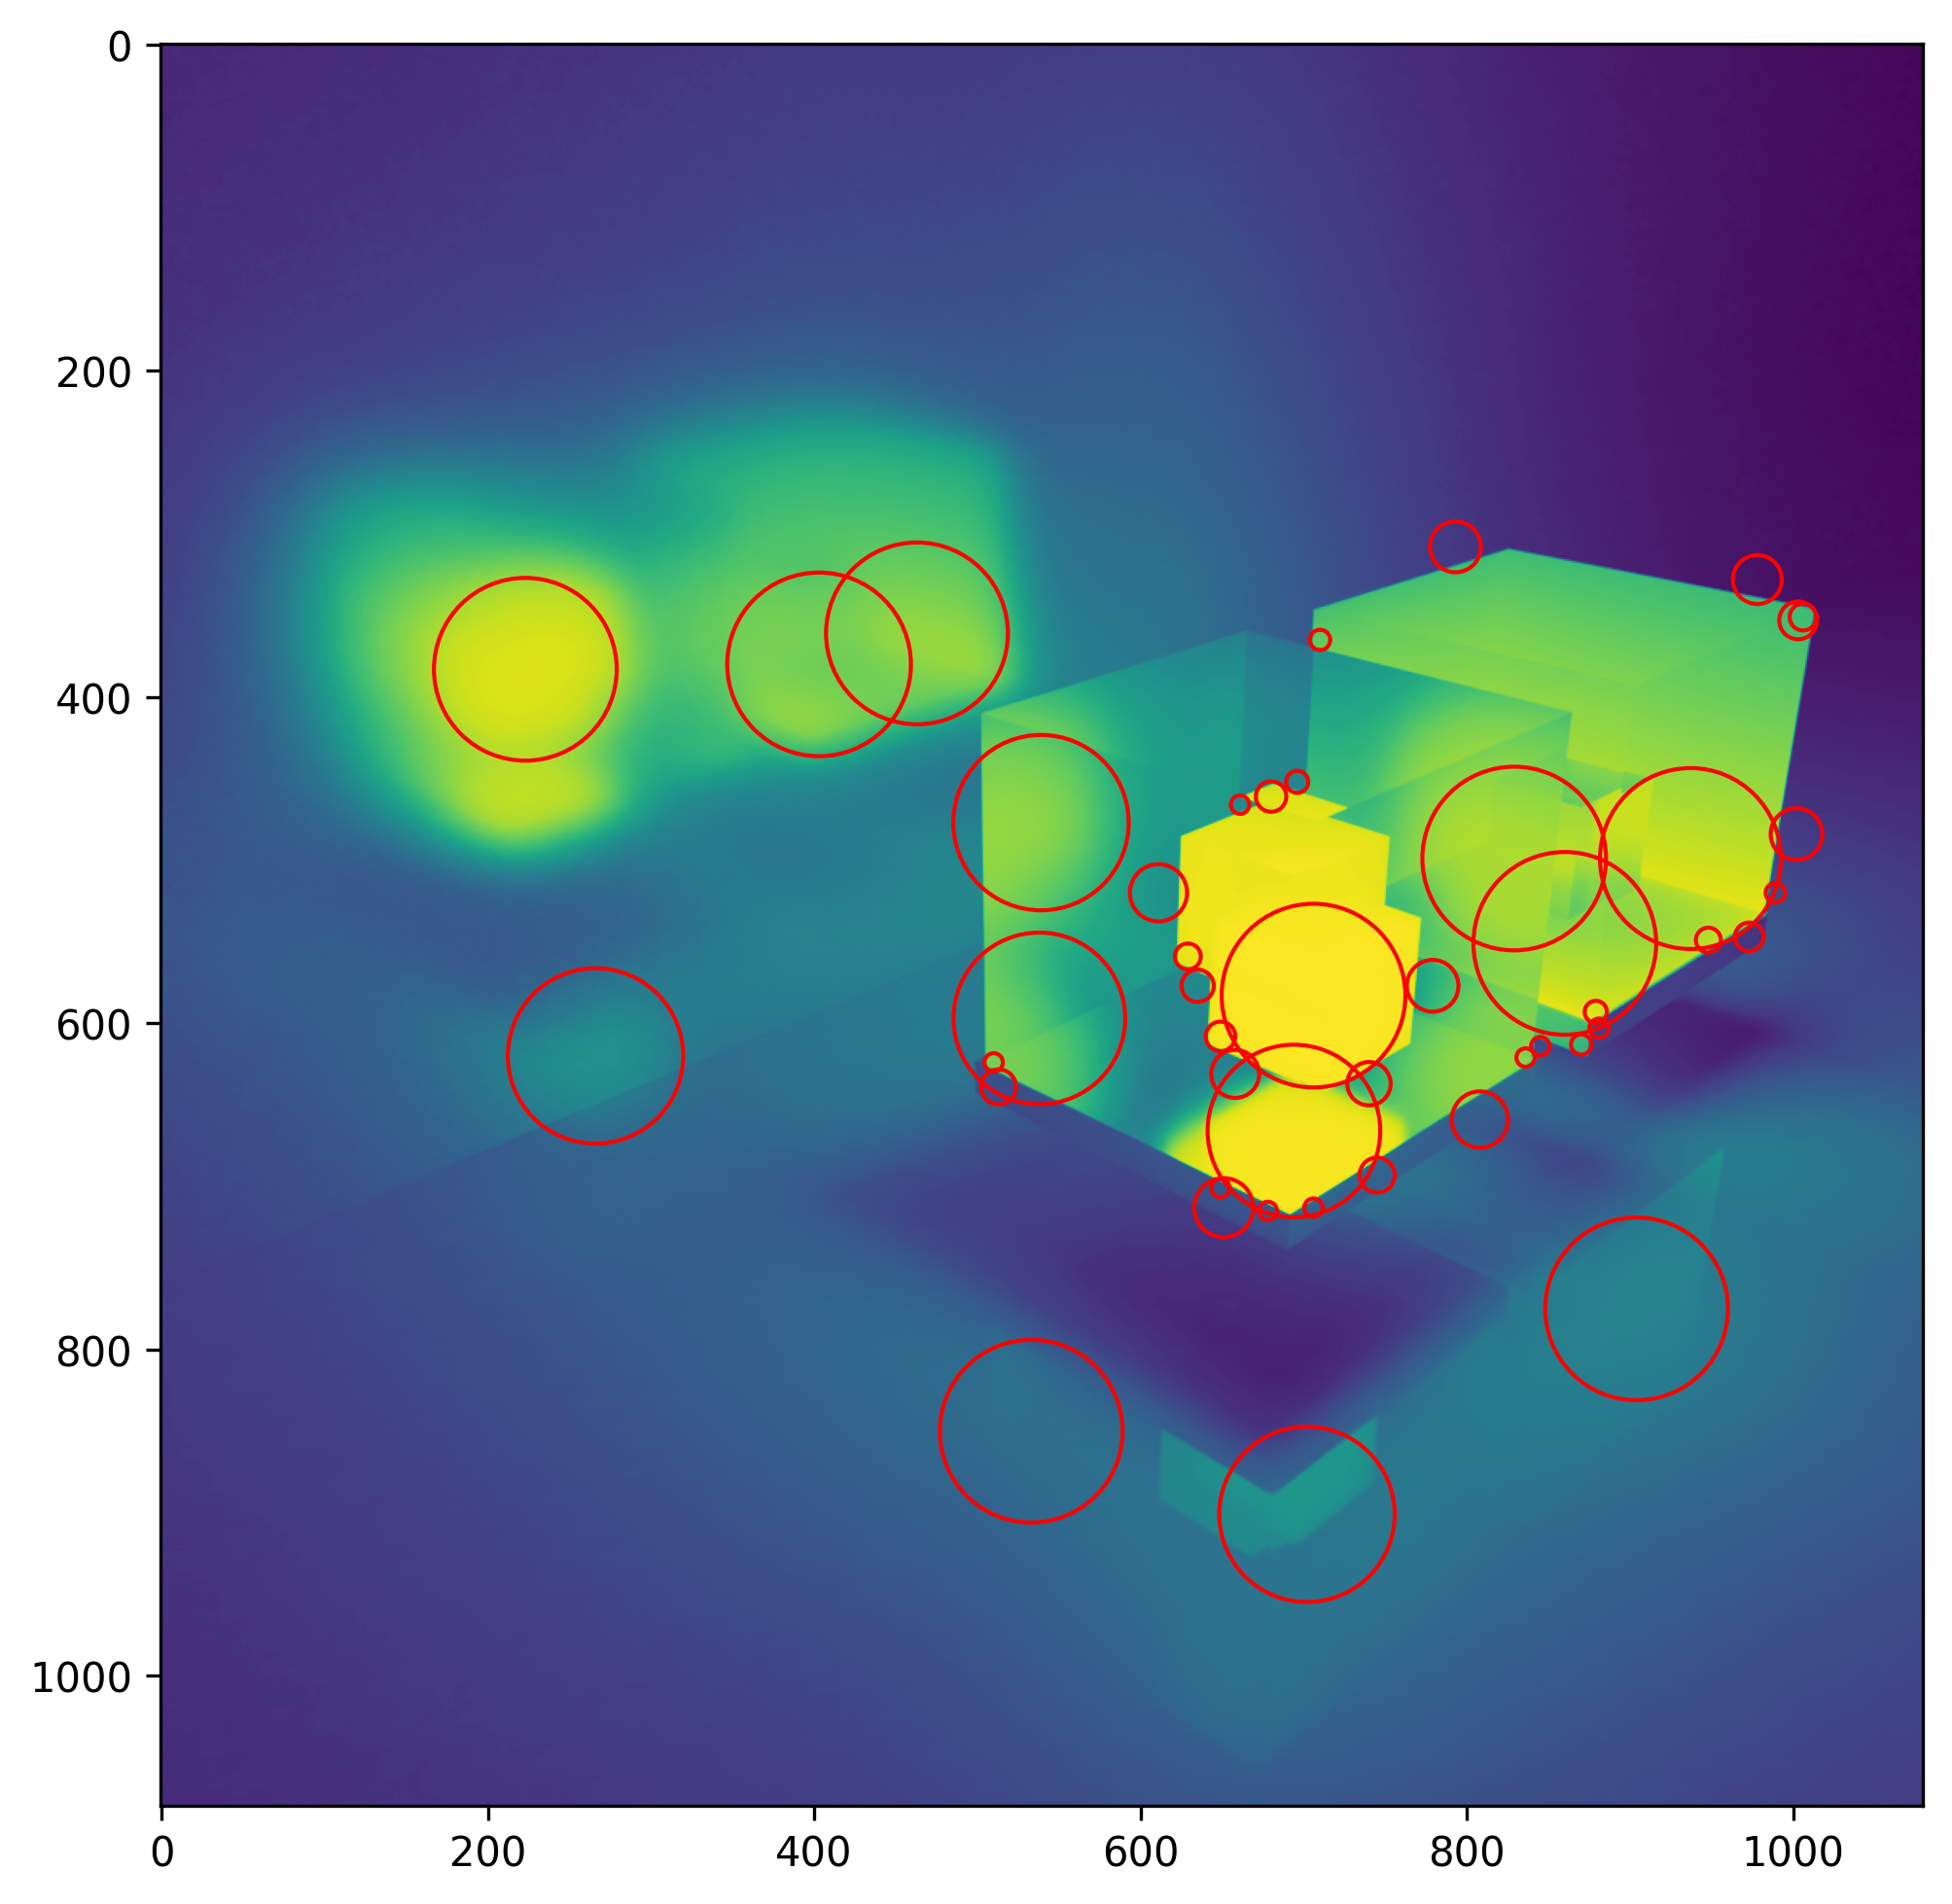

In [43]:
# Feature response as a function of sigma
# Sunflower Image from: https://local12.com/news/local/deerfield-township-sunflower-field-attracts-shutterbugs
image_base = load_image("sunflower_field.jpg")[:, :, 0]
sigmas = np.arange(4.0, 80.0, 1.0)
features = compute_multi_scale_features(image_base, sigmas, 0.8)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

# Feature response as a function of sigma
image_base = load_image("light_cubes_base.png")[:, :, 0]
sigmas = np.arange(4.0, 80.0, 1.0)
features = compute_multi_scale_features(image_base, sigmas, 0.4)
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_circ_features(image_base, features, plt.gca())

## P2.3 Image Warping

(basically the same as the breakout session: they will be asked to implement image warping and then apply a few kernels to the images. They will be asked to "pad" their input image, so that the entire image is still in the domain of the output.)

## P2.4 Implementing Some Simple Feature Descriptors

(Similar to the breakout session: I will ask them to implement some simple feature descriptors)

I will also ask them to choose some different transformations that show circumstances under which the feature descriptors work well or work very poorly. You should select a total of four transformations: two that show the feature matches working well and two in which the feature matching is poor. Apply each transformation to a reference image of your choosing and show the feature matching performance on each. Under what circumstances do each of the descriptors perform poorly?

For each set of matches, you may tune the threshold for "accepting" the feature matches manually so as to highlight your results. Note that, in practice, this is not possible, since we would like to do everything automatically.

I will ask them to implement both feature comparison strategies: minimum L2 norm between the two images or using the minimal *ratio distance* as discussed in class.